In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit
from numba.types import pyobject
import numba
import time
import jit_functions as jf

In [3]:
log_gammas = np.logspace(-3,3, 5)
gammas = np.array([float(10**(2*p)) for p in range(-3,3)])

# Creating my OBABO class element

In [37]:
# defining functions for potential and force
@njit(parallel=True)
def U(x):
    return - x**2/2 + x**4/4

@njit(parallel=True)
def force(q):
    F = q - q**3
    return F

obabo_step = jf.make_obabo(force)
OBABO = jf.Scheme(obabo_step, force, U)

# Graphing the results of the simulation

Time Elapsed: 9.46020770072937


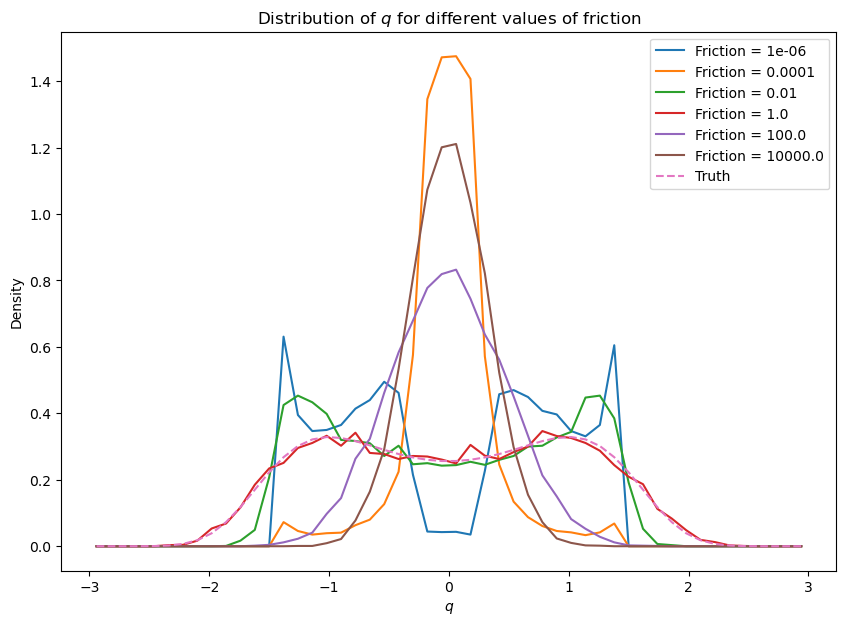

In [6]:
# running 1000 simulations, each taking 100000 steps of size 0.01
start_time =time.time()
OBABO.friction_graph(1000, 0.01, 10000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 3.652972459793091


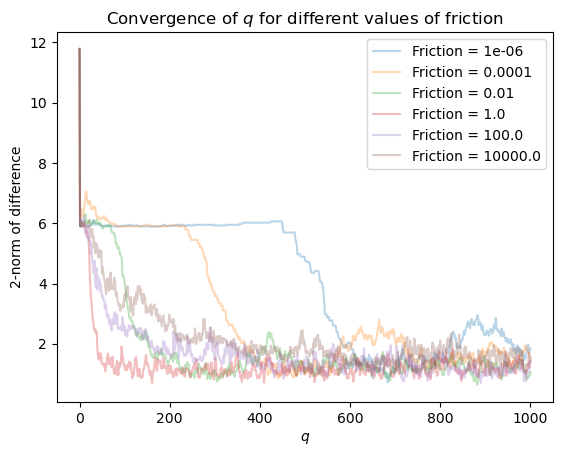

In [7]:
start_time =time.time()
OBABO.convergence_graph(1000, 0.01, 100, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 24.071633338928223


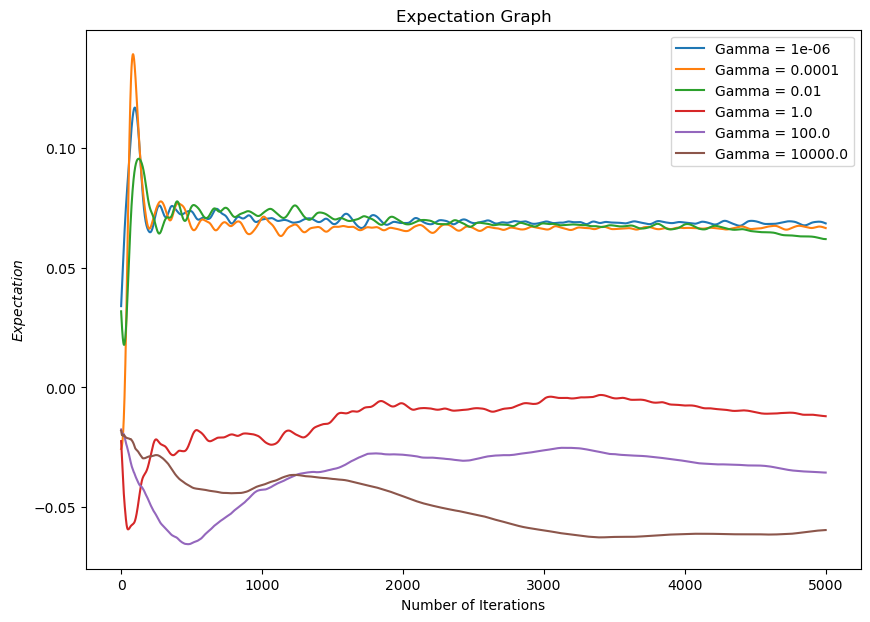

In [8]:
start_time =time.time()
OBABO.expectation_graph(U,10000, 0.01, 100, gammas, q_init = np.random.normal(size =100), p_init = np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Gamma = 0.001
Gamma = 0.03162277660168379
Gamma = 1.0
Gamma = 31.622776601683793
Gamma = 1000.0
Time Elapsed: 521.7983429431915


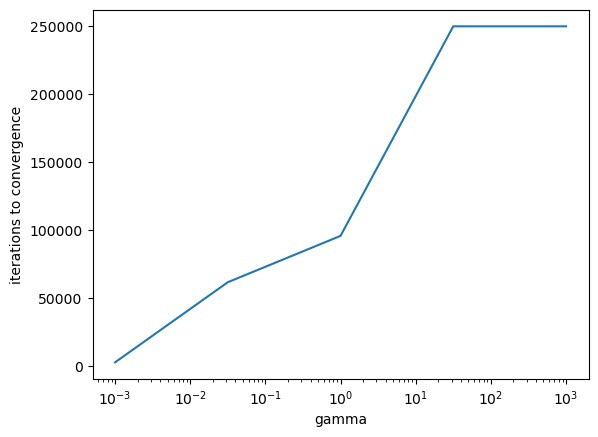

In [38]:
start_time =time.time()
OBABO.convergence_time_graph(1/10, jf.nothing, 0, 0.01, log_gammas,q_init = np.random.normal(size =10), p_init =np.random.normal(size = 10))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

In [11]:
#OBABO.convergence_time_graph(1/10, square, 1.041797296487154, 0.01, lingammas,q_init = np.random.normal(size =1000), p_init =np.random.normal(size = 1000))

Time Elapsed: 68.28719449043274


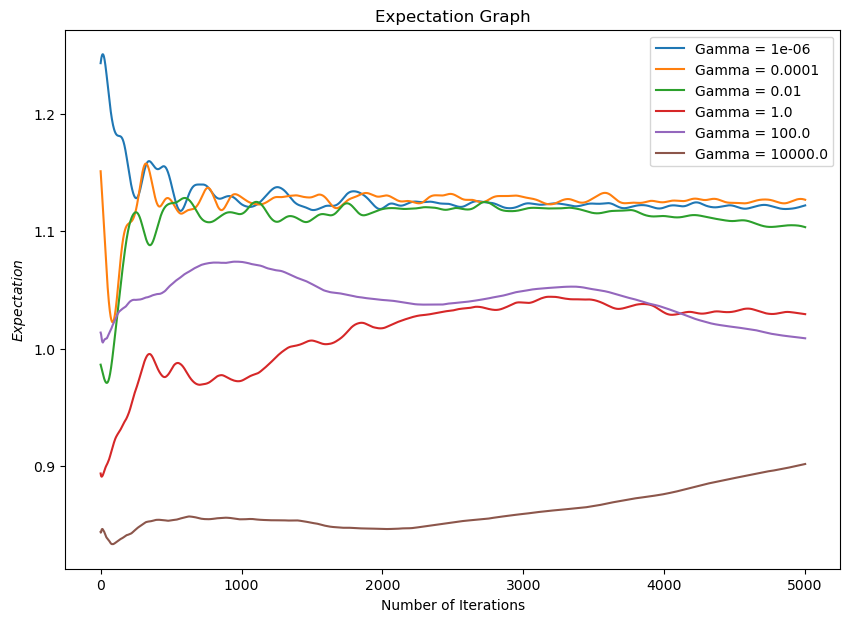

In [12]:
start_time =time.time()
OBABO.expectation_graph(jf.square,10000, 0.01, 1, gammas, q_init = np.random.normal(size =100), p_init =np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 76.04467821121216


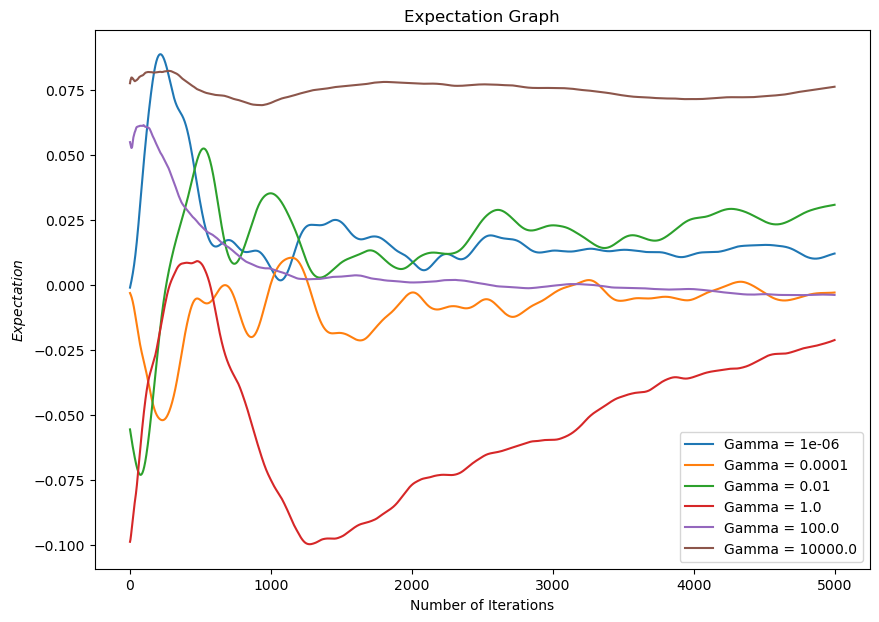

In [13]:
start_time =time.time()
OBABO.expectation_graph(jf.nothing,10000, 0.01, 100, gammas, q_init = np.random.normal(size =100), p_init = np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

# A new potential
$U(x) = \log{( e^{2(x-1)^2} + e^{2(x+1)^2} + e^{-(x-3)^2} + e^{(x+3)^2})}$

In [23]:
# defining the method
@jit(nopython=True)
def potential(x):
    return -np.log( np.exp(-2*(x-1)**2) + np.exp(-2*(x+1)**2) + np.exp(-2*(x+3)**2) + np.exp(-2*(x-3)**2) )

@jit(nopython=True)
def force_2(x):
    r = -4*(x-1)*np.exp(-2*(x-1)**2)  -4*(x+1)*np.exp(-2*(x+1)**2)  -4*(x+3)*np.exp(-2*(x+3)**2) -4*(x-3)*np.exp(-2*(x-3)**2)
    F = r/(np.exp(-2*(x-1)**2) + np.exp(-2*(x+1)**2) + np.exp(-2*(x+3)**2) + np.exp(-2*(x-3)**2))
    return F

obabo_step_2 = jf.make_obabo(force_2)
OBABO_2 = jf.Scheme(obabo_step_2, force_2, potential)

Time Elapsed: 24.183144092559814


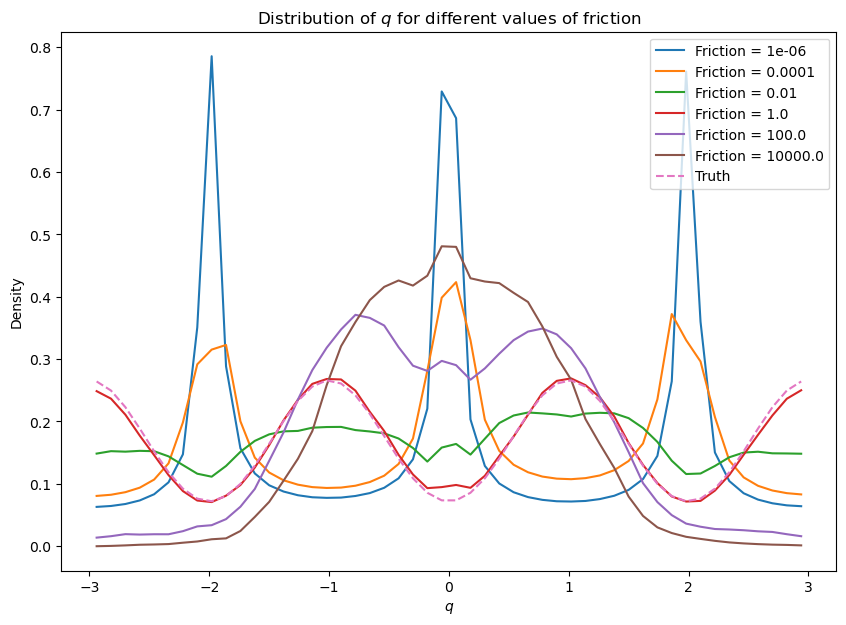

In [25]:
start_time =time.time()
OBABO_2.friction_graph(10000, 0.01, 1000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 35.39547395706177


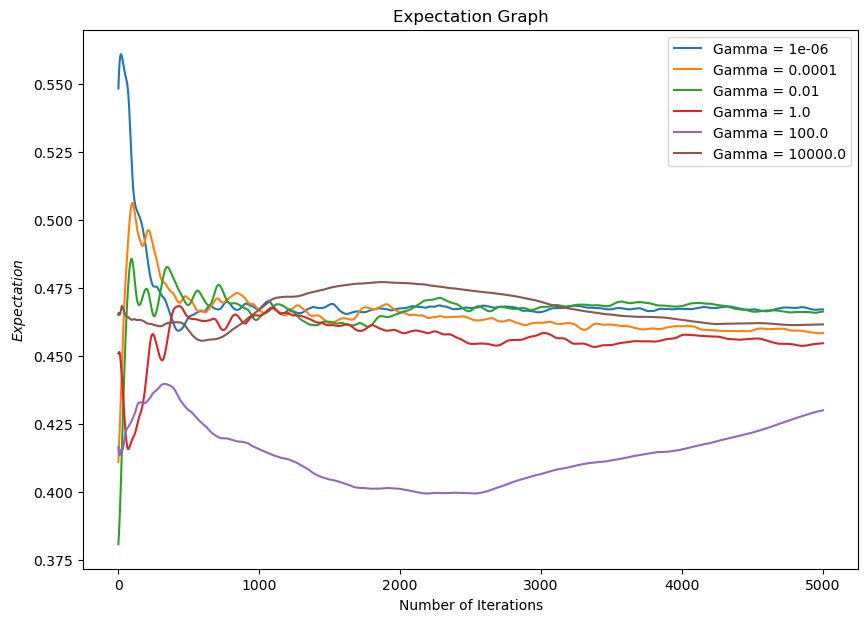

In [20]:
start_time =time.time()
OBABO_2.expectation_graph(potential,10000, 0.01, 1000, gammas, q_init =np.random.normal(size = 100), p_init = np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

In [ ]:
print(f"Time Elapsed: {end_time - start_time}")
start_time = time.time()
OBABO_2.expectation_graph(square, 10000, 0.01, 10000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time - start_time}")

In [ ]:
start_time =time.time()
OBABO.convergence_time_graph(1/10, jf.nothing, 0, 0.01, log_gammas,q_init = np.random.normal(size =10), p_init =np.random.normal(size = 10))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

# Assymmetrical Potentials

In [26]:
@jit(nopython=True)
def potential_3(x):
    return (x-0.9)**4/8 - (x-1)**2/1.2

@jit(nopython=True)
def force_3(x):
    F = -(x-0.9)**3/4 + (x-1)*2/1.2
    return F

In [27]:
obabo_step_3 = jf.make_obabo(force_3)

In [28]:
OBABO_3 = jf.Scheme(obabo_step_3, force_3, potential_3)

Time Elapsed: 25.75420570373535


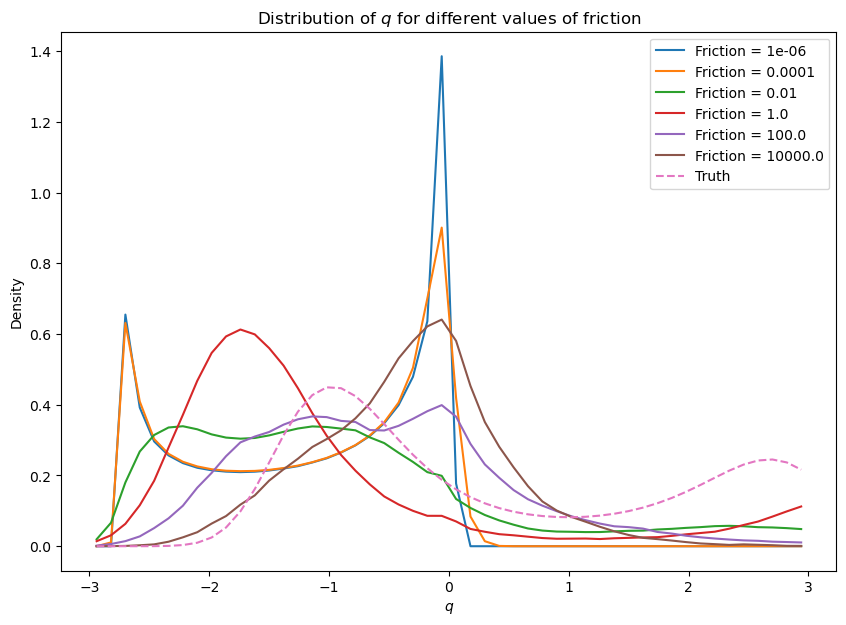

In [29]:
start_time =time.time()
OBABO_3.friction_graph(10000, 0.01, 1000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Gamma = 0.001
Gamma = 0.03162277660168379
Gamma = 1.0
Gamma = 31.622776601683793
Gamma = 1000.0
Time Elapsed: 529.6766996383667


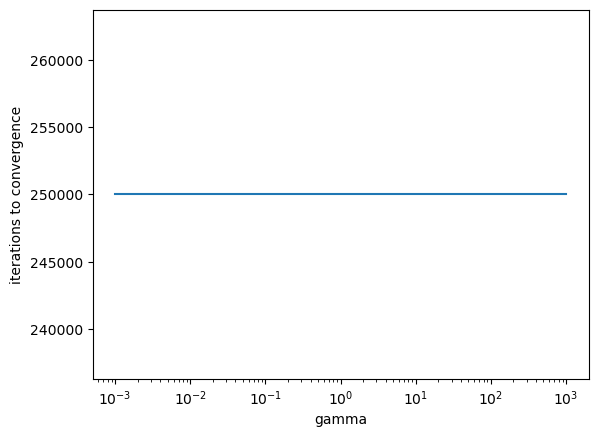

In [39]:
start_time =time.time()
OBABO_3.convergence_time_graph(1/10, jf.nothing, 0, 0.01, log_gammas,q_init = np.random.normal(size =10), p_init =np.random.normal(size = 10))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

# 4 mode asymmetrical

In [32]:
@jit(nopython=True)
def potential_4(x):
    return -np.log( np.exp(-2*(x-1)**2) + 2*np.exp(-2*(x+1)**2) + 1.5*np.exp(-2*(x+3)**2) + np.exp(-2*(x-3)**2) )

@jit(nopython=True)
def force_4(x):
    r = -4*(x-1)*np.exp(-2*(x-1)**2)  -2*4*(x+1)*np.exp(-2*(x+1)**2)  -1.5*4*(x+3)*np.exp(-2*(x+3)**2) -4*(x-3)*np.exp(-2*(x-3)**2)
    F = r/potential_4( np.exp(-2*(x-1)**2) + 2*np.exp(-2*(x+1)**2) + 1.5*np.exp(-2*(x+3)**2) + np.exp(-2*(x-3)**2) )
    return F

obabo_step_4 = jf.make_obabo(force_3)
OBABO_4 = jf.Scheme(obabo_step_4, force_4, potential_4)

Time Elapsed: 39.33087348937988


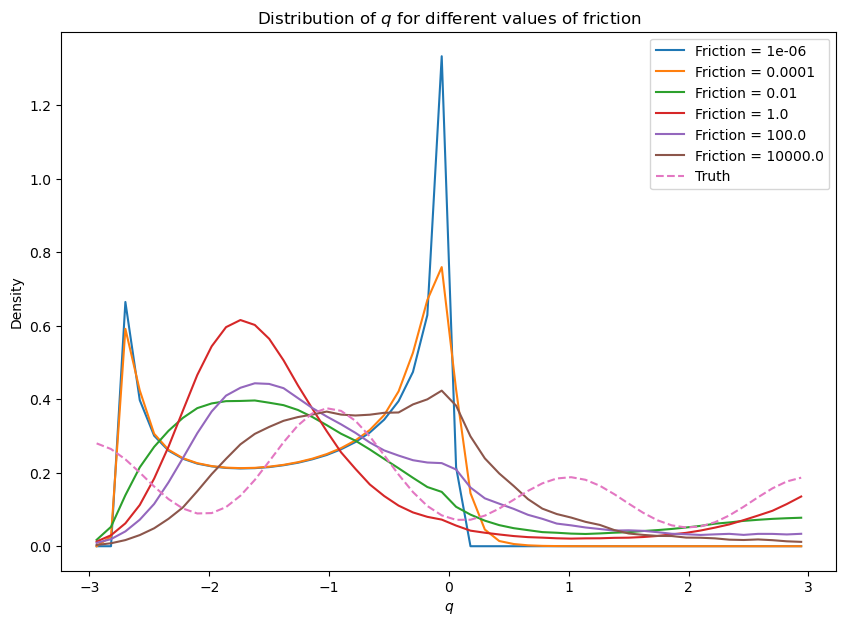

In [35]:
start_time =time.time()
OBABO_4.friction_graph(20000, 0.01, 1000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")